# Optimisation: First example

This example shows you how to run a global optimisation with Pints.

First, we import pints:

In [1]:
import pints

Next, we need a model: any class that implements the [pints.ForwardModel interface](http://pints.readthedocs.io/en/latest/core_classes_and_methods.html#forward-model).

Usually, you'd write a class for this purpose (that wrapped around whatever simulation package you wanted to use to generate your time series data). But you could also use a pure-Python model.

In the example, we use a [logistic model](https://en.wikipedia.org/wiki/Logistic_function), provided by [Pints's toy model module](http://pints.readthedocs.io/en/latest/toy/index.html).

In [2]:
import pints.toy as toy
model = toy.LogisticModel()

This model has two parameters: A growth rate (which determines the steepness of the curve) and a carrying capacity (which determines the number the curve converges to).
For the example, we simply pick some nice values:

In [3]:
real_parameters = [0.015, 500]

Finally, we create a list of times (in a real experiment, these would be the times at which the time series was sampled)

In [4]:
import numpy as np
times = np.linspace(0, 1000, 1000)

We now have everything we need to run a simulation and generate some toy data:

In [5]:
values = model.simulate(real_parameters, times)

We can use Matplotlib (or any other plotting package) to have a look at the generated data:

In [6]:
import matplotlib.pyplot as plt

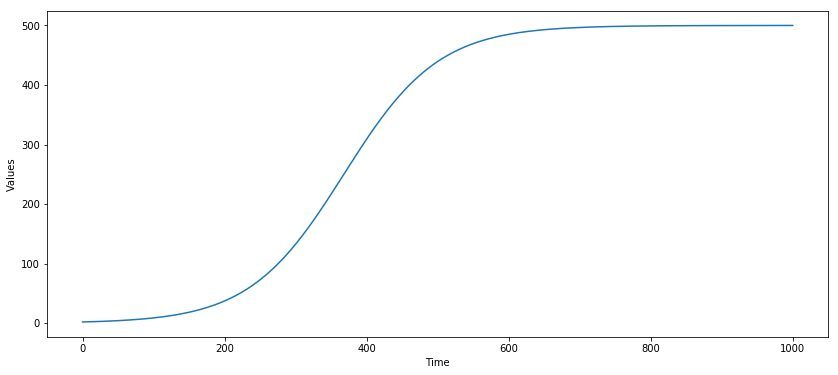

In [7]:
plt.figure(figsize=(14, 6))
plt.xlabel('Time')
plt.ylabel('Values')
plt.plot(times, values)
plt.show()

If you like, you can make it more realistic at this point by adding some noise:

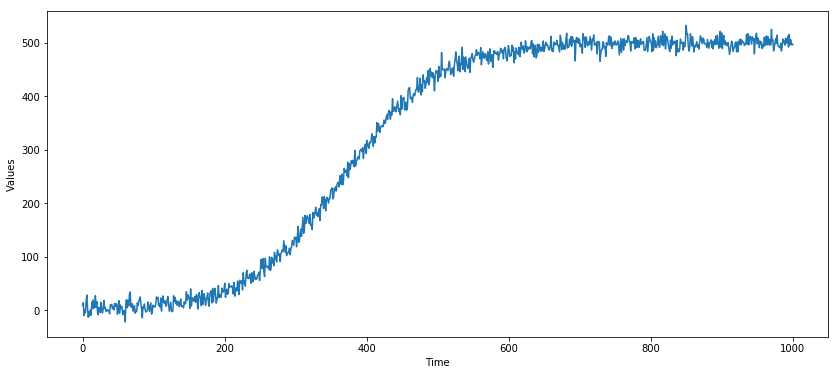

In [8]:
values += np.random.normal(size=values.shape) * 10

plt.figure(figsize=(14, 6))
plt.xlabel('Time')
plt.ylabel('Values')
plt.plot(times, values)
plt.show()

We now set up an optimisation, to see if we can recover our original parameters from this data.

First, we define a problem (in this case a [single-valued time series fitting problem](https://pints.readthedocs.io/en/latest/core_classes_and_methods.html#pints.SingleOutputProblem)):

In [9]:
problem = pints.SingleOutputProblem(model, times, values)

We then define an [error measure](http://pints.readthedocs.io/en/latest/error_measures.html) on this problem:

In [10]:
error = pints.SumOfSquaresError(problem)

A lot of real problems have physical constraints on the values the parameters can take, so in this example we add them in the form of [boundaries](http://pints.readthedocs.io/en/latest/boundaries.html):

In [11]:
boundaries = pints.RectangularBoundaries([0, 200], [1, 1000])

Finally, we define an initial position to start searching at

In [12]:
x0 = np.array([0.5, 500])

We now run an optimisation, using the [xNES](http://pints.readthedocs.io/en/latest/optimisers/xnes.html) method (although we could also have used a different global [optimiser](http://pints.readthedocs.io/en/latest/optimisers/index.html), like [CMA-ES](http://pints.readthedocs.io/en/latest/optimisers/cmaes.html) or [PSO](http://pints.readthedocs.io/en/latest/optimisers/pso.html)):

In [13]:
found_parameters, found_value = pints.optimise(
    error,
    x0,
    boundaries=boundaries,
    method=pints.XNES,
    )

Minimising error measure
Using Exponential Natural Evolution Strategy (xNES)
Running in sequential mode.
Population size: 6
Iter. Eval. Best      Time m:s
0     6      7.88e+07   0:00.0
1     12     3.96e+07   0:00.0
2     18     3.76e+07   0:00.0
3     24     3.76e+07   0:00.0
20    126    5712038    0:00.1
40    246    734912.5   0:00.1
60    366    130676.2   0:00.1
80    486    95962.66   0:00.1
100   606    95947.06   0:00.2
120   726    95947.06   0:00.2
140   846    95947.06   0:00.2
160   966    95947.06   0:00.2
180   1086   95947.06   0:00.3
200   1206   95947.06   0:00.3
220   1326   95947.06   0:00.3
240   1446   95947.06   0:00.4
260   1566   95947.06   0:00.4
280   1686   95947.06   0:00.4
300   1806   95947.06   0:00.5
320   1926   95947.06   0:00.5
340   2046   95947.06   0:00.6
360   2166   95947.06   0:00.6
380   2286   95947.06   0:00.6
390   2340   95947.06   0:00.7
Halting: No significant change for 200 iterations.


We can now look at the quality of the fit by running a simulation with the obtained parameters and plotting it on top of the noisy data:

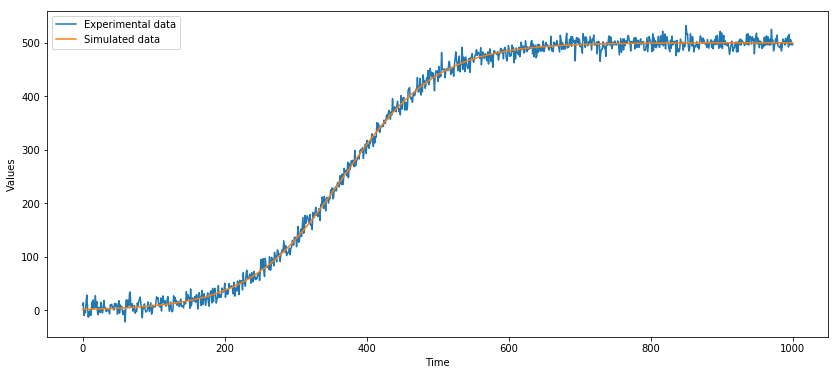

In [14]:
values2 = model.simulate(found_parameters, times)

plt.figure(figsize=(14, 6))
plt.xlabel('Time')
plt.ylabel('Values')
plt.plot(times, values, label='Experimental data')
plt.plot(times, values2, label='Simulated data')
plt.legend()
plt.show()

## Comparing the solution with the true parameters

Because this was a toy model, we can also compare the parameters with the known true parameters:

In [15]:
print('Found solution:          True parameters:' )
for k, x in enumerate(found_parameters):
    print(pints.strfloat(x) + '    ' + pints.strfloat(real_parameters[k]))

Found solution:          True parameters:
 1.50174345960627578e-02     1.49999999999999994e-02
 5.00370183650449064e+02     5.00000000000000000e+02


So it looks like we were close, but not _exactly_ at the right parameters.

Why didn't we find _exactly_ the right solution?

To investigate this, we start by looking at the error measure, evaluated at the true solution and at the obtained solution:

In [16]:
print('Error at obtained solution: ')
print(error(found_parameters))

print('Error at true solution: ')
print(error(real_parameters))

Error at obtained solution: 
95947.05526018786
Error at true solution: 
96202.5975973817


Another way to compare them is to plot the error function on a line drawn between these points:

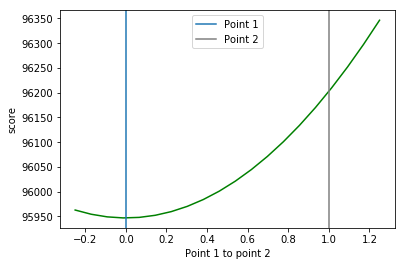

In [17]:
import pints.plot
fig, axes = pints.plot.function_between_points(error, point_1=found_parameters, point_2=real_parameters)
axes.set_ylabel('score')
plt.show()

So it looks like we found a solution that's slightly _better_ than the true solution - how can that be?

The answer comes from the noise we added to our data, which introduced a _bias_ in the obtained results.
We can see this by looking at the noise itself:

In [18]:
noise = values - model.simulate(real_parameters, times)
print(np.mean(noise))

0.4703549192538935


So when we added this noise to our simulated trace, it caused a slight vertical shift in the data.
And when we optimised to that shifted data, the optimiser found model parameters that could compensate for this shift.

We can see this by inspecting the mean of the _estimated noise_:

In [19]:
noise = values - model.simulate(found_parameters, times)
print(np.mean(noise))

0.047544200980740456


So it seems the final error is a result of our data including a _finite_ sample of noise from a Gaussian distribution, which has some non-zero offset, i.e. the [standard error of the mean](https://en.wikipedia.org/wiki/Standard_error).